In [1]:
import numpy as np
import gurobipy as gp
GRB = gp.GRB

In [3]:
def rcpspexact(taches, durees, pred, ressources, limites, matricelien, exclusions=None):
    # Paramètres de base
    n = len(taches)             # Nombre de tâches
    k = len(ressources)         # Nombre de types de ressources
    durees = list(map(int, durees)) # Eviter les np.int64
    limites = list(map(int, limites)) # Pareil
    H = max(n, sum(durees))     # Horizon de planification (suffisamment grand)

    # Modèle et variables
    model = gp.Model("RCPSP")

    start = model.addVars(n, vtype=gp.GRB.INTEGER)        # Début de chaque tâche
    x     = model.addVars(n, H, vtype=gp.GRB.BINARY)      # x[i,t] = 1 si tâche i active à t
    Cmax  = model.addVar(vtype=gp.GRB.INTEGER)            # Date de fin du projet

    # Contraintes predecesseurs
    for i in range(n):
        for j in pred[i]:
            j_pred = taches.index(j)
            model.addConstr(start[i] >= start[j_pred] + durees[j_pred])

    # Contraintes x[i,t] (Big-M)
    M = H + 1
    for i in range(n):
        for t in range(H):
            model.addConstr(t >= start[i] - (1 - x[i, t]) * M)
            model.addConstr(t <= start[i] + durees[i] - 1 + (1 - x[i, t]) * M)

    # Contraintes ressources
    for t in range(H):
        for r in range(k):
            model.addConstr(
                gp.quicksum(matricelien[i, r] * x[i, t] for i in range(n)) <= limites[r]
            )

    # Définition de Cmax
    for i in range(n):
        model.addConstr(Cmax >= start[i] + durees[i])

    # Contraintes d'exclusion éventuelles (graph coloring)
    if exclusions:
        for (i, j) in exclusions:
            model.addConstr(start[i] != start[j])

    # Objectif
    model.setObjective(Cmax, gp.GRB.MINIMIZE)

    # Lancement du solveur
    model.optimize()

    # Résultat
    if model.status == gp.GRB.OPTIMAL:
        return [int(start[i].X) for i in range(n)]
    else:
        print("Pas de solution optimale trouvée.")


In [4]:
#Test de la fonction rcpspexact
taches      = ['a','b','c','d','e','f','g','h','i']
durees      = np.array([3,4,2,6,5,3,7,5,8])
pred        = [{},{'a'},{'a'},{'b','c'},{'c'},{'c'},{'e'},{'e','f'},{'d','g','h'}]
ressources  = ['ressource1','ressource2']
limites     = np.array([2,3])
matricelien = np.array([[1,1],[0,1],[2,1],[1,3],[0,0],[2,2],[2,0],[1,1],[0,0]])

debuts = rcpspexact(taches, durees, pred, ressources, limites, matricelien)
print(dict(zip(taches, debuts)))


Set parameter Username
Set parameter LicenseID to value 2661355
Academic license - for non-commercial use only - expires 2026-05-06
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G4 CPU @ 1.10GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 881 rows, 397 columns and 2106 nonzeros
Model fingerprint: 0x292a3ba3
Variable types: 0 continuous, 397 integer (387 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 9e+01]
Found heuristic solution: objective 25.0000000
Presolve removed 881 rows and 397 columns
Presolve time: 0.03s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.04 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 25 

Optimal solut

In [5]:
def GRAPHCOLORING(A):

    n = A.shape[0]  # Nombre de sommets

    # Teste successivement c couleurs de 1 à n
    for c in range(1, n + 1):

        #Modèle et Variables
        model = gp.Model()
        color = model.addVars(n, vtype=GRB.INTEGER, lb=0, ub=c - 1)  # Couleur de chaque sommet (entier de 0 à c-1)

        # Contrainte d’incompatibilité pour chaque arête : color[i] ≠ color[j]
        M = c
        for i in range(n):
            for j in range(i + 1, n):
                if A[i, j] == 1:
                    b = model.addVar(vtype=GRB.BINARY)

                    model.addConstr(color[i] + 1 <= color[j] + M * b)
                    model.addConstr(color[j] + 1 <= color[i] + M * (1 - b))

        # Objectif
        model.setObjective(0, GRB.MINIMIZE)

        #Solveur
        model.optimize()

        if model.status == GRB.OPTIMAL:
            return {i: int(color[i].X) for i in range(n)}
        else:
            print("Aucune coloration trouvée")


In [6]:
import matplotlib.pyplot as plt

def plot_rcpsp_schedule(taches, durees, debuts):
    fig, ax = plt.subplots(figsize=(10, 0.5 * len(taches) + 2))
    yticks = []
    ylabels = []

    for i, (tache, debut, duree) in enumerate(zip(taches, debuts, durees)):
        ax.barh(i, duree, left=debut, height=0.4, color=plt.cm.tab20(i))
        ax.text(debut + duree / 2, i, tache, va='center', ha='center', color='white', fontsize=8)
        yticks.append(i)
        ylabels.append(tache)

    ax.set_yticks(yticks)
    ax.set_yticklabels(ylabels)
    ax.set_xlabel("Temps")
    ax.set_ylabel("Tâches")
    ax.set_title("Diagramme de Gantt - Ordonnancement RCPSP")
    ax.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()


In [7]:
import networkx as nx

def plot_colored_graph(A, coloration):
    G = nx.Graph()

    n = A.shape[0]
    G.add_nodes_from(range(n))

    # Ajout des arêtes selon la matrice d'adjacence
    for i in range(n):
        for j in range(i + 1, n):
            if A[i, j] == 1:
                G.add_edge(i, j)

    # Construction d’une palette de couleurs (1 couleur par valeur unique)
    unique_colors = sorted(set(coloration.values()))
    color_map = plt.cm.get_cmap('tab20', len(unique_colors))
    print(f"Nombre de couleur unique = {len(unique_colors)}")

    # Attribuer une couleur à chaque sommet
    node_colors = [color_map(coloration[i]) for i in range(n)]

    # Affichage du graphe
    pos = nx.spring_layout(G, seed=42) 
    nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=800, font_color='white', font_weight='bold', edge_color='gray')
    plt.title("Coloration du graphe (Graph Coloring via RCPSP)")
    plt.show()


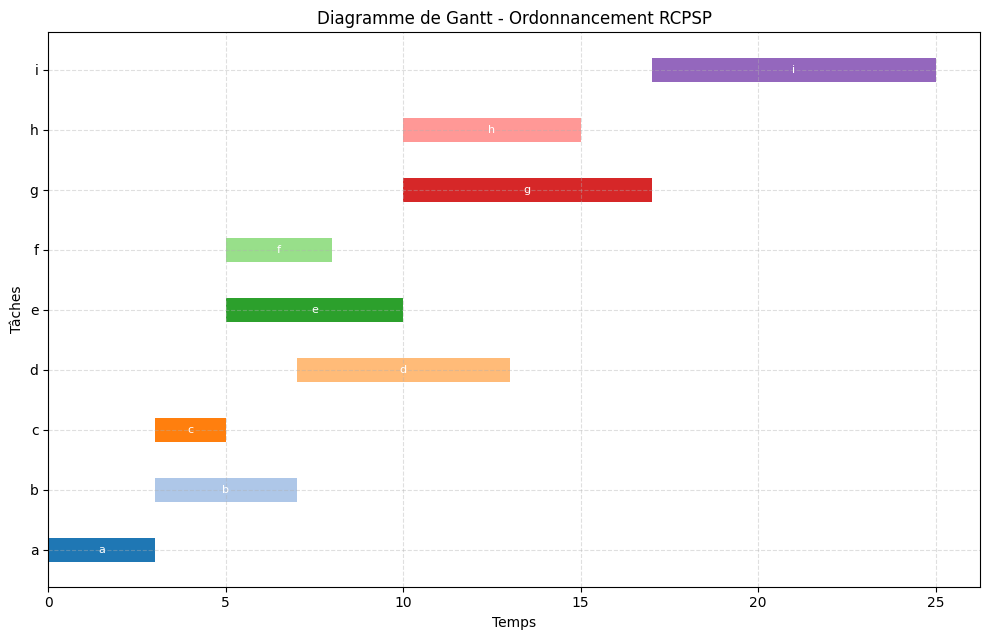

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G4 CPU @ 1.10GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 16 rows, 14 columns and 48 nonzeros
Model fingerprint: 0x76d9bb65
Variable types: 0 continuous, 14 integer (8 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 0 rows and 6 columns
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Aucune coloration trouvée
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G4 CPU @ 1.10GHz, instruction set [SSE2|AVX|

C:\Users\mathi\AppData\Local\Temp\ipykernel_18872\1215024071.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab20', len(unique_colors))


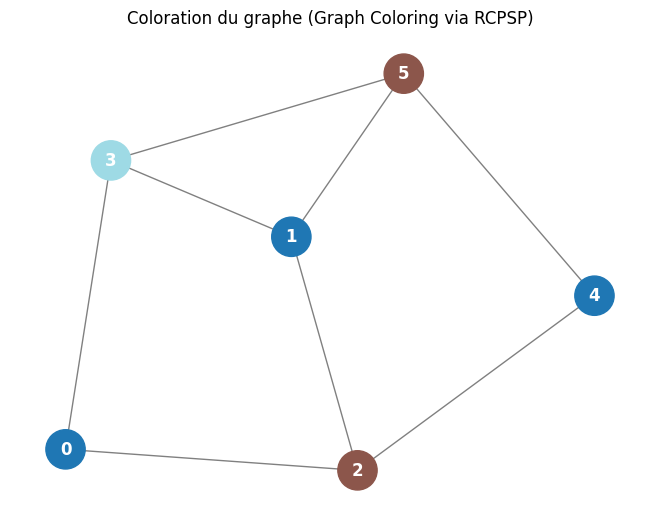

In [8]:
#GRAPH-COLORING via RCPSP
A=np.array([[0, 0, 1, 1, 0, 0],
            [0, 0, 1, 1, 0, 1],
            [1, 1, 0, 0, 1, 0],
            [1, 1, 0, 0, 0, 1],
            [0, 0, 1, 0, 0, 1],
            [0, 1, 0, 1, 1, 0]])

# Pour RCPSP
plot_rcpsp_schedule(taches, durees, debuts)

coloration = GRAPHCOLORING(A)
print("Coloration trouvée :", coloration)


plot_colored_graph(A, coloration)